In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [37]:
def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100
mape_scorer = make_scorer(mape, greater_is_better = False)

## Load Data

In [2]:
train = pd.read_csv("../data/training_set.csv")
train_y = np.ravel(train.groupby(by = ["Game_ID"]).sum().values)
train = train.drop(["Country", "Rounded Viewers", "Game_ID"], axis = 1)
test = pd.read_csv("../data/test_set.csv").drop("Total_Viewers", axis = 1)
ids = test.pop("Game_ID")
game_data = pd.read_csv("../data/game_data.csv")

In [15]:
game_data

,Season,Game_ID,Game_Date,Team,Location,Wins_Entering_Gm,Losses_Entering_Gm,Team_Minutes,Final_Score,Lead_Changes,Ties,Largest_Lead,Full_Timeouts,Short_Timeouts,Qtr_4_Score,L2M_Score
0,2016-17,21600001,10/25/2016,CLE,H,0,0,240.0,117.0,1.0,3.0,32.0,4.0,1.0,82.0,113.0
1,2016-17,21600001,10/25/2016,NYK,A,0,0,240.0,88.0,0.0,1.0,4.0,4.0,2.0,64.0,84.0
2,2016-17,21600002,10/25/2016,POR,H,0,0,240.0,113.0,6.0,6.0,13.0,5.0,0.0,77.0,104.0
3,2016-17,21600002,10/25/2016,UTA,A,0,0,240.0,104.0,5.0,1.0,8.0,5.0,2.0,83.0,102.0
4,2016-17,21600003,10/25/2016,GSW,H,0,0,240.0,100.0,1.0,2.0,4.0,3.0,1.0,77.0,100.0
5,2016-17,21600003,10/25/2016,SAS,A,0,0,240.0,129.0,1.0,1.0,29.0,5.0,1.0,97.0,122.0
6,2016-17,21600004,10/26/2016,MIA,A,0,0,240.0,108.0,7.0,6.0,19.0,4.0,1.0,80.0,104.0
7,2016-17,21600004,10/26/2016,ORL,H,0,0,240.0,96.0,7.0,7.0,7.0,4.0,2.0,69.0,92.0
8,2016-17,21600005,10/26/2016,DAL,A,0,0,265.0,121.0,2.0,7.0,1.0,7.0,4.0,85.0,110.0
9,2016-17,21600005,10/26/2016,IND,H,0,0,265.0,130.0,2.0,1.0,14.0,5.0,2.0,94.0,110.0


## Preprocess

In [3]:
for column in ["Away_Team", "Home_Team"]:
    train[column] = train[column].astype('category')

t1 = train.drop_duplicates().reset_index().drop("index", axis = 1)
t2 = pd.get_dummies(t1, columns = ["Away_Team", "Home_Team"])
season_encoder = LabelEncoder()
date_encoder = LabelEncoder()
t2["Season"] = season_encoder.fit_transform(t2["Season"])
t2["Game_Date"] = date_encoder.fit_transform(t2["Game_Date"])
test["Season"] = season_encoder.transform(test["Season"])
test["Game_Date"] = date_encoder.transform(test["Game_Date"])
test = pd.get_dummies(test, columns = ["Away_Team", "Home_Team"])

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    7.9s finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 3 folds for each of 148 candidates, totalling 444 fits


[Parallel(n_jobs=1)]: Done 444 out of 444 | elapsed:   44.6s finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 3 folds for each of 59 candidates, totalling 177 fits


[Parallel(n_jobs=1)]: Done 177 out of 177 | elapsed:   10.6s finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 3 folds for each of 58 candidates, totalling 174 fits


[Parallel(n_jobs=1)]: Done 174 out of 174 | elapsed:   10.4s finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


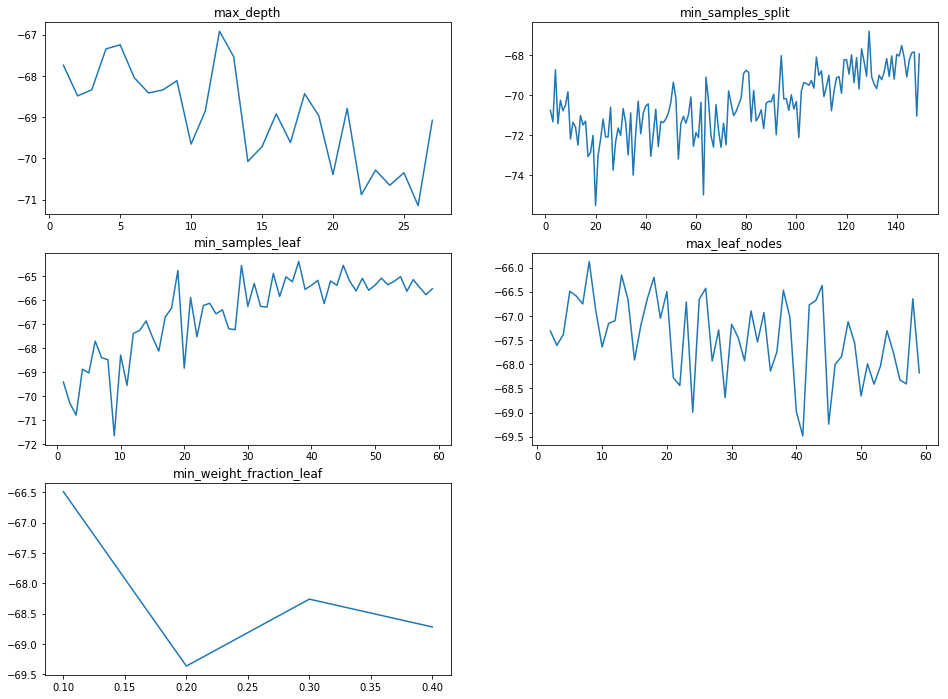

In [46]:
model = RandomForestRegressor(n_estimators = 20)

# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(model, param_grid = {parameter: num_range}, scoring = mape_scorer, verbose = 1)
    grid_search.fit(t2, train_y)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

# parameters and ranges to plot
param_grid = {"n_estimators": np.arange(5, 200, 1),
              "max_depth": np.arange(1, 28, 1),
              "min_samples_split": np.arange(2, 150, 1),
              "min_samples_leaf": np.arange(1,60,1),
              "max_leaf_nodes": np.arange(2,60,1)}

# min_samples_leaf -> 20-40
# 

index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1

In [35]:
%%time
model = RandomForestRegressor(n_jobs = 4, criterion = 'mae', verbose = 1)

params = {'max_depth'        : [5, 10, 15, 20, 30],
          'criterion'        : ['mse', 'mae'],
          'min_samples_leaf' : [1, 2, 4],
          'min_samples_split': [2, 5, 10],
          'n_estimators'     : [10, 30, 50, 70]}
grid_search = GridSearchCV(estimator = model, 
                           param_grid = params, cv = 5, verbose = 0, 
                           scoring = mape_scorer)
grid_search.fit(t2, train_y)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    3.0s finished
[Parallel(n_j

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | ela

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Par

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.2s finished
[Parallel(n_j

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | ela

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Par

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    8.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    7.6s finished
[Parallel(n_j

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.5s finished
[Parallel(n_j

[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.5s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    6.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    5.0s finished
[Parallel(n_j

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:    7.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: 

KeyboardInterrupt: 

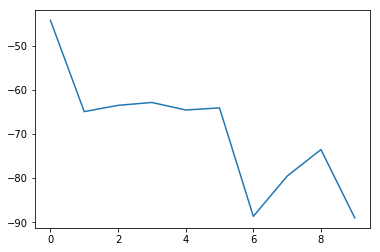

In [10]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()